## Driver code comparing output of different preproc pipelines 
- Note: currently using output after atlas-based grouping
- Atlas used: aparc (Freesurfer) DKT-31 Mindboggle (ANTs: https://mindboggle.readthedocs.io/en/latest/labels.html) 

### Steps
- import data csvs 
- visualize data distributions 
- correlate features across pipelines
- compare performance of machine-learning model (scikit-learn)
- compare performance of statsmodels (ols or logit)

In [1]:
import sys
import numpy as np
import pandas as pd
import itertools
import seaborn as sns

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

sys.path.append('../')
from lib.data_handling import *
from lib.data_stats import *

### Data paths

In [31]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
#proj_dir = '/Users/nikhil/projects/compare-surf-tools/'
data_dir = proj_dir + 'data/'
fs60_dir = data_dir + 'fs60_group_stats/'
qc_dir =  '/home/nikhil/projects/CT_reproduce/data/QC/'
results_dir = data_dir + 'results/'

demograph_file = 'ABIDE_Phenotype.csv'
dkt_roi_names = 'DKT_parcel_map_FS_CIVET.csv'

ants_file = 'ABIDE_ants_thickness_data.csv' #uses modified (mindboggle) dkt atlas with 31 ROIs
civet_file = 'ABIDE_civet2.1_thickness_test1.csv'

fs53_file = 'ABIDE_fs5.3_thickness.csv'
fs51_file = 'cortical_fs5.1_measuresenigma_thickavg.csv' 
fs60_lh_file = 'lh.aparc.thickness.table.test1' #'aparc_lh_thickness_table.txt' #'lh.aparc.thickness.table.test1'
fs60_rh_file = 'rh.aparc.thickness.table.test1' #'aparc_rh_thickness_table.txt' #'rh.aparc.thickness.table.test1'


### Global Vars

In [3]:
subject_ID_col = 'SubjID'

### Load data

In [4]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# ROI names
dkt_roi_map = pd.read_csv(data_dir + dkt_roi_names)

# CIVET 2.1
civet_data = pd.read_csv(data_dir + civet_file, dtype={subject_ID_col: str})
print('shape of civet data {}'.format(civet_data.shape))
civet_data_std = standardize_civet_data(civet_data, subject_ID_col, dkt_roi_map)
print('shape of stdized civet data {}'.format(civet_data_std.shape))
print('')

# ANTs
ants_data = pd.read_csv(data_dir + ants_file, header=2)
print('shape of ants data {}'.format(ants_data.shape))
ants_data_std = standardize_ants_data(ants_data, subject_ID_col)
print('shape of stdized ants data {}'.format(ants_data_std.shape))
print('')

# FS
fs53_data = pd.read_csv(data_dir + fs53_file)
print('shape of fs53 data {}'.format(fs53_data.shape))
fs53_data_std = standardize_fs_data(fs53_data, subject_ID_col)
print('shape of stdized fs53 data {}'.format(fs53_data_std.shape))
print('')

fs51_data = pd.read_csv(data_dir + fs51_file)
print('shape of fs51 data {}'.format(fs51_data.shape))
fs51_data_std = standardize_fs_data(fs51_data, subject_ID_col)
print('shape of stdized fs51 data {}'.format(fs51_data_std.shape))
print('')

fs60_lh_data = pd.read_csv(fs60_dir + fs60_lh_file, delim_whitespace=True)
fs60_rh_data = pd.read_csv(fs60_dir + fs60_rh_file, delim_whitespace=True)
print('shape of fs60 data l: {}, r: {}'.format(fs60_lh_data.shape,fs60_rh_data.shape))

fs60_data_std = standardize_fs60_data(fs60_lh_data, fs60_rh_data, subject_ID_col)
print('shape of stdized fs60 data {}'.format(fs60_data_std.shape))

shape of civet data (899, 65)
shape of stdized civet data (899, 65)

shape of ants data (1101, 99)
shape of stdized ants data (1101, 90)

shape of fs53 data (976, 74)
shape of stdized fs53 data (976, 74)

shape of fs51 data (1112, 74)
shape of stdized fs51 data (1112, 74)

shape of fs60 data l: (1047, 36), r: (1047, 36)
shape of left and right merge fs6.0 df (1047, 71)
shape of stdized fs60 data (1047, 71)


### Create master dataframe

In [66]:
data_dict = {'civet': civet_data_std,
            'ants' : ants_data_std,
            'fs60' : fs60_data_std,
            'fs53' : fs53_data_std,
            'fs51' : fs51_data_std}

na_action = 'drop' # options: ignore, drop; anything else will not use the dataframe for analysis. 
master_df_raw, common_subs, common_roi_cols = combine_processed_data(data_dict, subject_ID_col, na_action)

# Add demographic columns to the master_df_raw
useful_demograph = demograph[[subject_ID_col,'SEX','AGE_AT_SCAN','DX_GROUP','SITE_ID']].copy()

# DX_GROUP: (orginal: 1:ASD, 2:Controls, after shift 0:ASD, 1:Controls)
# Shift to (0 and 1 instead of 1 and 2 for statsmodels)
useful_demograph['DX_GROUP'] = useful_demograph['DX_GROUP']-1
useful_demograph['SEX'] = useful_demograph['SEX']-1
_,useful_demograph[subject_ID_col] = useful_demograph[subject_ID_col].str.rsplit('_', 1).str

master_df_raw = pd.merge(master_df_raw, useful_demograph, how='left', on=subject_ID_col)

print('\nmaster df shape after adding demographic info {}'.format(master_df_raw.shape))
print('\nNumber of common subjects {}({}), ROIs {}'.format(len(common_subs), master_df_raw[master_df_raw['pipeline']=='fs60']['DX_GROUP'].value_counts().to_dict(),len(common_roi_cols)))


Number of datasets: 5
Finding common subject and columns
dataset : fs51
common subs: 1112
dataset : civet
common subs: 899
dataset : fs60
common subs: 863
dataset : fs53
common subs: 779
dataset : ants
common subs: 778
Number of common subjects and columns: 778, 63

checking fs51 dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (778, 64)

checking civet dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (1556, 64)

checking fs60 dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (2334, 64)

checking fs53 dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (3112, 64)

checking ants dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of t

### QC filters
- Manual (Gleb or Maarten)
- Automatic (Amadou) 

In [77]:
qc_type = 'maarten' #condition: master_df['QC_maarten']==0, master_df['QC_gleb'].isin['1','-+1']

if qc_type in ['maarten','gleb']:
    qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': str})
    master_df = pd.merge(master_df_raw, qc_df, how='left', on=subject_ID_col)
    master_df = master_df[master_df['QC_maarten']==0]
    print('Filtering based on {} QC. Resultant number of subjects {} ({}) (out of {})'.format(qc_type,len(master_df[subject_ID_col].unique()),master_df[master_df['pipeline']=='fs60']['DX_GROUP'].value_counts().to_dict(),len(common_subs)))
    common_subs = master_df[subject_ID_col].unique()
else:
    master_df = master_df_raw
    print('No QC performed. master_df shape {}'.format(len(master_df[subject_ID_col].unique())))
    


Filtering based on maarten QC. Resultant number of subjects 748 ({0: 341, 1: 407}) (out of 778)


### Correlation between pipelines

In [68]:
possible_pairs = list(itertools.combinations(data_dict.keys(), 2))
xcorr_pairs_df = pd.DataFrame()
for pair in possible_pairs:
    pipe1 = pair[0]
    pipe2 = pair[1]
    df1 = master_df[master_df['pipeline']==pipe1][[subject_ID_col]+common_roi_cols]
    df2 = master_df[master_df['pipeline']==pipe2][[subject_ID_col]+common_roi_cols]
    xcorr_df = cross_correlations(df1,df2,subject_ID_col)
    xcorr_df['pipeline_pair'] = np.tile(str('{}-{}'.format(pair[0],pair[1])),len(xcorr_df))
    xcorr_pairs_df = xcorr_pairs_df.append(xcorr_df)
    print('Avg cross correlation between {} & {} = {:4.2f}\n'.format(pipe1,pipe2,np.mean(xcorr_df['correlation'].values)))
    

Avg cross correlation between fs51 & civet = 0.48

Avg cross correlation between fs51 & fs60 = 0.86

Avg cross correlation between fs51 & fs53 = 0.90

Avg cross correlation between fs51 & ants = 0.43

Avg cross correlation between civet & fs60 = 0.51

Avg cross correlation between civet & fs53 = 0.52

Avg cross correlation between civet & ants = 0.42

Avg cross correlation between fs60 & fs53 = 0.91

Avg cross correlation between fs60 & ants = 0.43

Avg cross correlation between fs53 & ants = 0.48



Shape of cross-corr df (620, 3), number of pairs 10


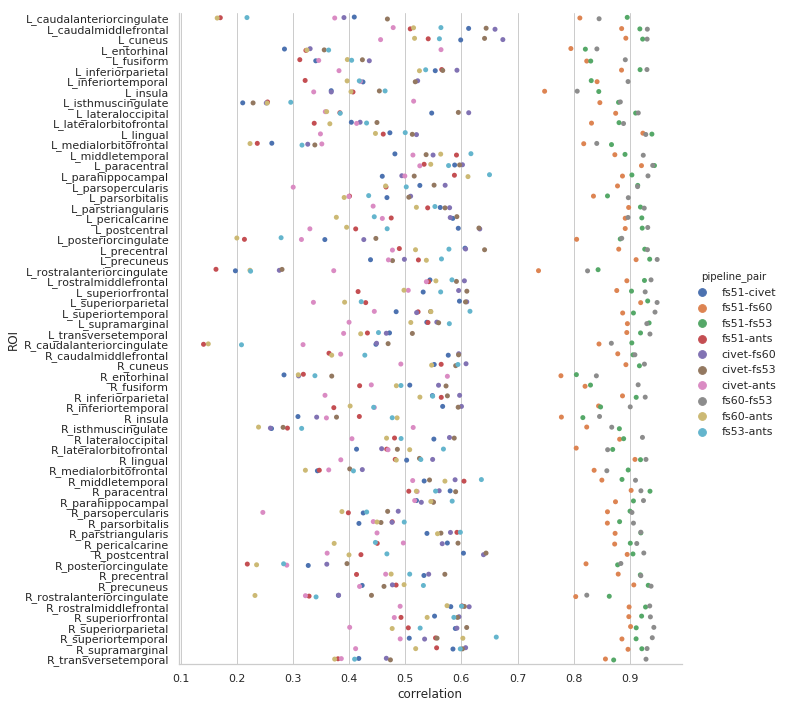

In [69]:
print('Shape of cross-corr df {}, number of pairs {}'.format(xcorr_pairs_df.shape, len(xcorr_pairs_df['pipeline_pair'].unique())))
roi_order = sorted(list(xcorr_pairs_df['ROI'].unique()))
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='correlation',y='ROI',hue='pipeline_pair',order=roi_order,
                data=xcorr_pairs_df,aspect=1,height=10,kind='strip')

### Compare ML performance 

In [70]:
roi_cols = common_roi_cols

model_type = 'regression'

if model_type.lower() == 'regression':
    outcome_col = 'AGE_AT_SCAN'
    covar_continuous_cols = []
    covar_cat_cols = ['SEX','SITE_ID','DX_GROUP'] 
    model = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=50)
else: 
    outcome_col = 'DX_GROUP'
    covar_continuous_cols = ['AGE_AT_SCAN']
    covar_cat_cols = ['SEX','SITE_ID'] 
    #model = svm.SVC(kernel='linear')
    model = RandomForestClassifier(n_estimators=50, max_depth=2,random_state=0)

ml_perf = computePipelineMLModels(master_df,roi_cols,covar_continuous_cols,covar_cat_cols,outcome_col,
                                  model_type,model)

Running ML classifer on 5 pipelines
Pipeline fs51
Using 3 col for 20 cat covar
Data shapes X (748, 82), y 748 (18.10m, 8.24sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-33.641, sd:9.481
Pipeline civet
Using 3 col for 20 cat covar
Data shapes X (748, 82), y 748 (18.10m, 8.24sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-47.008, sd:12.187
Pipeline fs60
Using 3 col for 20 cat covar
Data shapes X (748, 82), y 748 (18.10m, 8.24sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-37.510, sd:9.779
Pipeline fs53
Using 3 col for 20 cat covar
Data shapes X (748, 82), y 748 (18.10m, 8.24sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-34.407, sd:8.744
Pipeline ants
Using 3 col for 20 cat covar
Data shapes X (748, 82), y 748 (18.10m, 8.24sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-40.872, sd:10.978


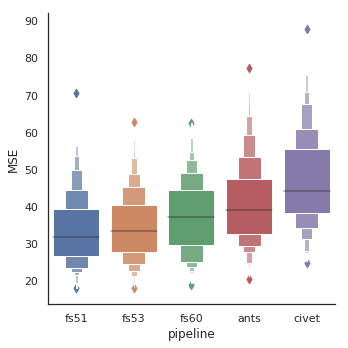

In [74]:
ml_perf['MSE'] = -1*ml_perf['neg_mean_squared_error']
x_order = ['fs51','fs53','fs60','ants','civet']
with sns.axes_style("white"): 
    g = sns.catplot(y='MSE',x='pipeline',kind='boxen',data=ml_perf, order=x_order)
    #g.set(ylim=(0, 80))


### Compare statsmodels performance 

In [79]:
save_sm_perf = True
roi_cols = common_roi_cols
covar_continuous_cols = ['AGE_AT_SCAN']
covar_cat_cols = ['SEX','SITE_ID']
outcome_col = 'DX_GROUP' #AGE_AT_SCAN #DX_GROUP #SEX
stat_model = 'logit' #ols #logit

sm_perf = computePipelineStatsModels(master_df,roi_cols,covar_continuous_cols,covar_cat_cols,
                                     outcome_col,stat_model)
print('Shape of the stats_models results df {}'.format(sm_perf.shape))

if save_sm_perf:
    save_path = '{}pipelines_sm_perf_{}_QC_{}_N_{}.pkl'.format(results_dir,outcome_col,qc_type,len(common_subs))
    print('Saving sm_perf dictionary at \n{}'.format(save_path))
    sm_perf.to_pickle(save_path)


Running 62 mass-univariate logit statsmodels on 5 pipelines
Pipeline fs51
Example statsmodel run:
 DX_GROUP ~ R_middletemporal + AGE_AT_SCAN + C(SEX) + C(SITE_ID)
Top 10 significant regions:
                        roi     t_val     p_val pipeline
23    L_posteriorcingulate -2.784963  0.005353     fs51
53  L_rostralmiddlefrontal -2.342126  0.019174     fs51
21  R_rostralmiddlefrontal -2.329715  0.019821     fs51
34           R_paracentral  2.266135  0.023443     fs51
10   L_medialorbitofrontal -2.095661  0.036112     fs51
56    L_transversetemporal -2.022827  0.043091     fs51
27               L_lingual -1.940489  0.052320     fs51
38      L_lateraloccipital -1.919676  0.054899     fs51
7       R_superiortemporal -1.915109  0.055479     fs51
33           R_postcentral -1.819249  0.068873     fs51
Pipeline civet
Example statsmodel run:
 DX_GROUP ~ R_middletemporal + AGE_AT_SCAN + C(SEX) + C(SITE_ID)
Top 10 significant regions:
                           roi     t_val     p_val pipeline
